### Vary dimension $p$
Vary the number of nodes $p$ and observe the error, bias, and time to run.
The number of samples scales with $(p+s) \log p$ for $s$ denoting the sparsity of the precision matrix.

In [1]:
from utils import *
from opt import *
from time import perf_counter
import pickle

from joblib import Parallel, delayed
import os

from sklearn.covariance import graphical_lasso

SEED = 10
SAVE = True
PATH = './results/vardim/'
N_CPUS = os.cpu_count() // 2
np.random.seed(SEED)

os.environ["OMP_NUM_THREADS"] = str(N_CPUS)

## Auxiliary functions

In [2]:
def create_data(p, n, mean_deg, group_prop, psd_fact=.05, weighted_edges=True, w_range=(.5, 1)):
    Z = create_Z(p, group_prop)

    # Create graph
    edge_prob = mean_deg/(p-1)
    A_true = generate_connected_er(p, edge_prob)

    if weighted_edges:
        weights = np.random.uniform(w_range[0], w_range[1], size=A_true.shape)
        weights = np.tril(weights)
        A_true = (weights + weights.T) * A_true

    # Precision matrix as loaded adjacency
    max_eigenval = np.abs(la.eigvalsh(A_true)[0])
    Theta = (max_eigenval + psd_fact) * np.eye(p) + A_true

    # Create signals
    Sigma = la.inv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
    Sigma_hat = X.T@X/n

    return Sigma_hat, Theta, Z


def compute_metric_err(Thetas_est, Thetas_true, n_exps, Zs=None, thr=.2, metric_type='err'):
    n_graphs = len(Thetas_est)
    n_samples = len(Thetas_est[0])

    metric = np.zeros((n_graphs, n_samples, n_exps))
    for i, Thetas in enumerate(Thetas_true):
        for j, Theta in enumerate(Thetas):
            p = Theta.shape[0]
            Theta_od = Theta*(1-np.eye(p))
            for k in range(n_exps):
            
                Theta_exps_od = Thetas_est[i][j][k]*(1-np.eye(p))

                if metric_type == 'err':
                    metric[i,j,k] = compute_frob_err(Theta_exps_od, Theta_od)
                elif metric_type == 'err-v2':
                    metric[i,j,k] = compute_frob_err(Theta_exps_od, Theta_od, pre_norm=True)
                elif metric_type == 'f1':
                    metric[i,j,k] = compute_f1_score(Theta_exps_od, Theta_od, thr)
                elif metric_type == 'bias':
                    mean_Theta = np.mean(mat2lowtri(np.abs(Theta_exps_od)))
                    metric[i,j,k] = compute_dp2(Theta_exps_od, Zs[i][j]) / mean_Theta if mean_Theta else 0
                elif metric_type == 'sqrt-bias':
                    mean_Theta = np.mean(mat2lowtri(np.abs(Theta_exps_od)))
                    metric[i,j,k] = np.sqrt(compute_dp2(Theta_exps_od, Zs[i][j])) / mean_Theta if mean_Theta else 0
                else:
                    raise ValueError('Unknown metric.')

    return metric
            


def plot_results(x_range, err, exps, y_label='Error', plot_f='semilogx', plt_args={}):

    mean_err = np.mean(err, axis=0)
    fig = plt.figure(figsize=(5,4))
    ax = fig.subplots()

    for i, exp in enumerate(exps):
        getattr(ax, plot_f)(x_range, mean_err[:,i], exp['fmt'], **plt_args, label=exp['leg'])

    ax.set_xlabel('Number of nodes')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()

def get_n_samples(n_nodes, n_edges, times=1):
    return int((n_nodes + n_edges)*np.log(n_nodes) * times)

def get_mu1_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def get_mu2_value(n_nodes, times=1):
    return times * (n_nodes - 1)**2

def run_exp(g, dim_range, data_p, exps, verb=False):
    Thetas_true = []
    Thetas_est = []
    Zs = []
    runingtimes = np.zeros((len(dim_range), len(exps)))
    for i, p in enumerate(dim_range):

        print('Graph', g+1, 'Number of nodes:', p)

        n = get_n_samples(p, p*data_p['mean_deg'])
        Sigma_hat, Theta, Z = create_data(p, n, **data_p)
        Thetas_true.append(Theta)
        Zs.append(Z)

        Theta_od = Theta*(1-np.eye(p))

        Thetas_est_e = np.zeros((len(exps), p,p))
        for j, exp in enumerate(exps):
            args = exp['args'].copy()

            t_init = perf_counter()
            if exp['model'] == 'glasso':
                args['alpha'] = get_mu1_value(p, n, args['alpha'] )
                _, Theta_est = graphical_lasso(Sigma_hat, **args)
            elif exp['model'] == 'fair_flasso':
                args['mu1'] = get_mu1_value(p, n, args['mu1'] )
                args['mu2'] = get_mu2_value(p, args['mu2'] ) 
                Theta_est = FairGLASSO_fista(Sigma_hat, Z=Z, **args)
            
            runingtimes[i,j] = perf_counter() - t_init
            Thetas_est_e[j] = Theta_est

            Theta_est_od = Theta_est*(1-np.eye(p))
            err = compute_frob_err(Theta_est_od, Theta_od)
            bias = compute_dp2(Theta_est, Z) / np.mean(mat2lowtri(np.abs(Theta_est_od))) if np.mean(mat2lowtri(np.abs(Theta_est_od))) else 0
            bias_v2 = compute_dp2(Theta_est_od, Z) / np.mean(mat2lowtri(np.abs(Theta_est_od))) if np.mean(mat2lowtri(np.abs(Theta_est_od))) else 0

            if verb:
                print(f'\t{exp["leg"]}: Err: {err:.4f} | Bias: {bias:.5f} | Bias v2: {bias_v2:.5f} | Time: {runingtimes[i,j]:.4f}')

        Thetas_est.append(Thetas_est_e)
        
    return Thetas_est, Thetas_true, runingtimes, Zs


In [3]:
# Experiment params
num_trials =  25

# Graph parameters
data_p = {
    'mean_deg': 5,
    'weighted_edges': True,
    'w_range': (.5, 1),
    'psd_fact': .1,
    'group_prop': [.25, .75],
}


DIM_RANGE = [50, 100, 150, 200]  #300, 500, 1000]
num_params = len(DIM_RANGE)
verbose = False

## Run experiment

In [4]:
PREC_TYPE = 'non-negative'

Exps = [
    {'model': 'glasso', 'args': {'alpha': .1, 'max_iter': 2000, 'tol': 1e-3}, 'fmt': 'v:', 'leg': 'GL'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 0, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o:', 'leg': 'FGL, 0'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 1, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o--', 'leg': 'FGL DP, 1'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 1, 'bias_type': 'nodewise', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 's--', 'leg': 'FGL NDP, 1'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 10, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o-', 'leg': 'FGL DP, 10'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 10, 'bias_type': 'nodewise', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 's-', 'leg': 'FGL NDP, 10'},

]

print('CPUs employed:', N_CPUS)
t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exp)
                                  (g, DIM_RANGE, data_p, Exps, verb=verbose) for g in range(num_trials))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')


Thetas_est, Thetas_true, runingtimes, Zs = zip(*results)

CPUs employed: 32
Graph 1 Number of nodes: 50
Graph 3 Number of nodes: 50
Graph 10 Number of nodes: 50
GraphGraph 23 Number of nodes: 50
 4 Number of nodes: 50
GraphGraph 21 Number of nodes: 50
 2 Number of nodes: 50
Graph 17 Number of nodes: 50
Graph 18 Number of nodes: 50
Graph 9 Number of nodes: 50
Graph 19 Number of nodes: 50
Graph 12 Number of nodes: 50
Graph 6 Number of nodes: 50
Graph 5 Number of nodes: 50
Graph 7 Number of nodes: 50
Graph 8 Number of nodes: 50
Graph 11 Number of nodes: 50
Graph 14 Number of nodes: 50
Graph 22 Number of nodes: 50
Graph 15 Number of nodes: 50
Graph 25 Number of nodes: 50
Graph 24 Number of nodes: 50
Graph 20 Number of nodes: 50
Graph 13 Number of nodes: 50
Graph 16 Number of nodes: 50
Graph 22 Number of nodes: 100
Graph 21 Number of nodes: 100
Graph 16 Number of nodes: 100
Graph 9 Number of nodes: 100
Graph 18 Number of nodes: 100
Graph 25 Number of nodes: 100
Graph 23 Number of nodes: 100
Graph 3 Number of nodes: 100
Graph 1 Number of nodes: 100

/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.161e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.351e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.193e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.967e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 6 Number of nodes: 100
Graph 24 Number of nodes: 100


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.890e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.284e-03
  warnings.warn(


Graph 14 Number of nodes: 100
Graph 15 Number of nodes: 100
Graph 4 Number of nodes: 100
Graph 21 Number of nodes: 150
Graph 10 Number of nodes: 100
Graph 16 Number of nodes: 150
Graph 13 Number of nodes: 150
Graph 9 Number of nodes: 150
Graph 25 Number of nodes: 150
Graph 19 Number of nodes: 100
Graph 5 Number of nodes: 100
Graph 23 Number of nodes: 150
Graph 20 Number of nodes: 150
Graph 2 Number of nodes: 150
Graph 11 Number of nodes: 150
Graph 7 Number of nodes: 150
Graph 3 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.993e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.035e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.166e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.162e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 10 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.454e-03
  warnings.warn(


Graph 22 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.500e-03
  warnings.warn(


Graph 21 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.407e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.046e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.035e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.100e-03
  warnings.warn(


Graph 18 Number of nodes: 150
Graph 12 Number of nodes: 150
Graph 1 Number of nodes: 150
Graph 17 Number of nodes: 150
Graph 25 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.627e-03
  warnings.warn(


Graph 16 Number of nodes: 200
Graph 24 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.097e-02
  warnings.warn(


Graph 8 Number of nodes: 150
Graph 11 Number of nodes: 200
Graph 23 Number of nodes: 200
Graph 3 Number of nodes: 200
Graph 14 Number of nodes: 150
Graph 4 Number of nodes: 150
Graph 15 Number of nodes: 150
Graph 6 Number of nodes: 150
Graph 22 Number of nodes: 200
Graph 19 Number of nodes: 150
Graph 5 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.628e-03
  warnings.warn(


Graph 10 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.949e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.700e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.522e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.636e-03
  warnings.warn(


Graph 18 Number of nodes: 200
Graph 12 Number of nodes: 200
Graph 17 Number of nodes: 200
Graph 14 Number of nodes: 200
Graph 4 Number of nodes: 200
Graph 6 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.458e-03
  warnings.warn(


Graph 13 Number of nodes: 200
Graph 9 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.807e-03
  warnings.warn(


Graph 7 Number of nodes: 200
Graph 2 Number of nodes: 200
Graph 20 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.302e-02
  warnings.warn(


Graph 16 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.043e-02
  warnings.warn(


Graph 3 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.147e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.022e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.413e-03
  warnings.warn(


Graph 24 Number of nodes: 200
Graph 10 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.210e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.107e-03
  warnings.warn(


Graph 12 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.271e-03
  warnings.warn(


Graph 18 Number of nodes: 300
Graph 1 Number of nodes: 200
Graph 8 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.554e-03
  warnings.warn(


Graph 14 Number of nodes: 300
Graph 5 Number of nodes: 200
Graph 19 Number of nodes: 200
Graph 15 Number of nodes: 200
Graph 4 Number of nodes: 300
Graph 13 Number of nodes: 300
Graph 21 Number of nodes: 300
Graph 7 Number of nodes: 300
Graph 2 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.487e-03
  warnings.warn(


Graph 24 Number of nodes: 300
Graph 9 Number of nodes: 300
Graph 22 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.034e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.667e-03
  warnings.warn(


Graph 23 Number of nodes: 300
Graph 25 Number of nodes: 300
Graph 1 Number of nodes: 300
Graph 11 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.587e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.289e-03
  warnings.warn(


Graph 17 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.325e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.077e-02
  warnings.warn(


Graph 6 Number of nodes: 300
Graph 20 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.690e-03
  warnings.warn(


Graph 15 Number of nodes: 300
Graph 8 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.502e-03
  warnings.warn(


Graph 5 Number of nodes: 300
Graph 19 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.632e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.607e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.651e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.061e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

----- Solved in 4.75e+02 seconds -----


### Save reulst and compute errors

In [5]:
if SAVE:
    file_name = PATH + f'vardim_graphs_{PREC_TYPE}_v1.pkl'
    data = {
        'Exps': Exps,
        'DIM_RANGE': DIM_RANGE,
        'Thetas_est': Thetas_est, 
        'Thetas_true': Thetas_true,
        'runingtimes': runingtimes,
        'Zs': Zs,
    }
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
        print('DATA SAVED AS:', file_name)

frob_err = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='err')
frob_err2 = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='err-v2')
f1_score = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='f1')
bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='bias')
sqrt_bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='sqrt-bias')

DATA SAVED AS: ./results/vardim/vardim_graphs_non-negative_v1.pkl


### Plot results

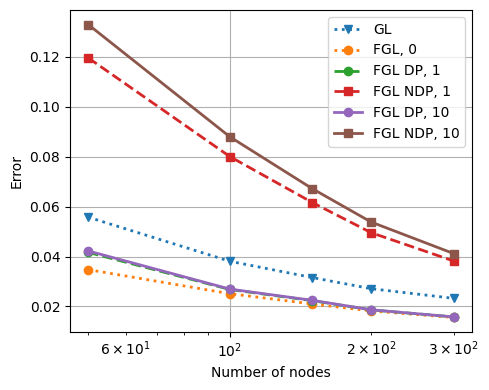

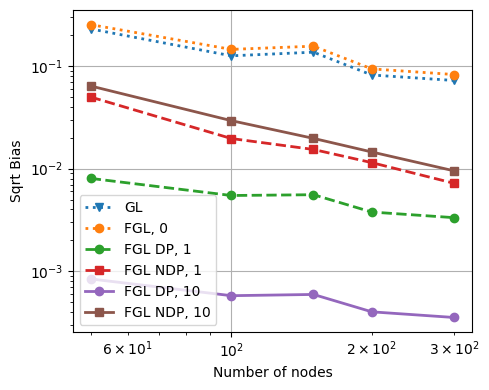

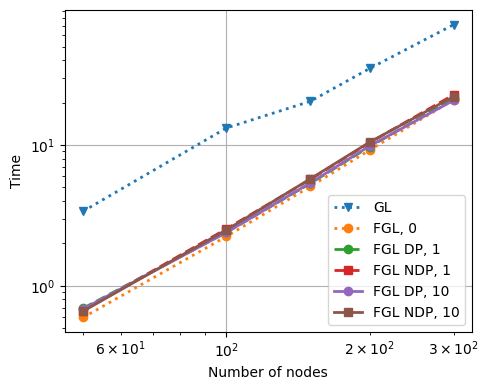

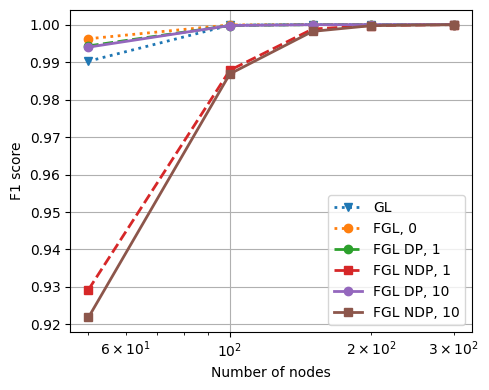

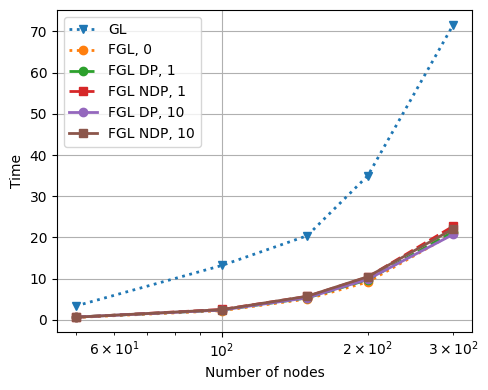

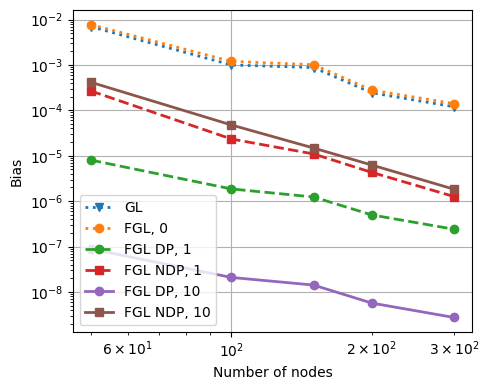

In [6]:
plt_args = { 'linewidth': 2 }
plot_results(DIM_RANGE, frob_err, Exps, y_label='Error', plt_args=plt_args)
plot_results(DIM_RANGE, sqrt_bias, Exps, y_label='Sqrt Bias', plt_args=plt_args, plot_f='loglog')
plot_results(DIM_RANGE, runingtimes, Exps, y_label='Time', plt_args=plt_args, plot_f='loglog')


# plot_results(DIM_RANGE, frob_err2, Exps, y_label='Error v2', plt_args=plt_args)
plot_results(DIM_RANGE, f1_score, Exps, y_label='F1 score', plt_args=plt_args)
plot_results(DIM_RANGE, runingtimes, Exps, y_label='Time', plt_args=plt_args, plot_f='semilogx')
plot_results(DIM_RANGE, bias, Exps, y_label='Bias', plt_args=plt_args, plot_f='loglog')




In [7]:
# # Load data
# file_name = PATH + 'vardim_graphs_v0'
# with open(file_name, 'rb') as f:
#     data = pickle.load(f)

# Exps = data['Exps']
# Thetas_est = data['Thetas_est']
# Thetas_true = data['Thetas_true']
# runingtimes = data['runingtimes']
# Zs = data['Zs']

## Run experiment - Any matrix

In [8]:
PREC_TYPE = None

Exps = [
    {'model': 'glasso', 'args': {'alpha': .1, 'max_iter': 2000, 'tol': 1e-3}, 'fmt': 'v:', 'leg': 'GL'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 0, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o:', 'leg': 'FGL, 0'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 1, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o--', 'leg': 'FGL DP, 1'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 1, 'bias_type': 'nodewise', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 's--', 'leg': 'FGL NDP, 1'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 10, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o-', 'leg': 'FGL DP, 10'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 10, 'bias_type': 'nodewise', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 's-', 'leg': 'FGL NDP, 10'},

]

print('CPUs employed:', N_CPUS)
t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exp)
                                  (g, DIM_RANGE, data_p, Exps, verb=verbose) for g in range(num_trials))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')


Thetas_est, Thetas_true, runingtimes, Zs = zip(*results)

CPUs employed: 32
Graph 1 Number of nodes: 50
Graph 2 Number of nodes: 50
Graph 3 Number of nodes: 50
Graph 4 Number of nodes: 50
Graph 5 Number of nodes: 50
Graph 6 Number of nodes: 50
Graph 7 Number of nodes: 50
Graph 8 Number of nodes: 50
Graph 9 Number of nodes: 50
Graph 10 Number of nodes: 50
Graph 11 Number of nodes: 50
Graph 12 Number of nodes: 50
Graph 13 Number of nodes: 50
Graph 14 Number of nodes: 50
Graph 15 Number of nodes: 50
Graph 16 Number of nodes: 50
Graph 17 Number of nodes: 50
Graph 18 Number of nodes: 50
Graph 19 Number of nodes: 50
Graph 20 Number of nodes: 50
Graph 21 Number of nodes: 50
Graph 22 Number of nodes: 50
Graph 23 Number of nodes: 50
Graph 24 Number of nodes: 50
Graph 25 Number of nodes: 50
Graph 6 Number of nodes: 100
Graph 25 Number of nodes: 100
Graph 22 Number of nodes: 100
Graph 7 Number of nodes: 100
Graph 13 Number of nodes: 100
Graph 19 Number of nodes: 100
Graph 4 Number of nodes: 100
Graph 10 Number of nodes: 100
Graph 15 Number of nodes: 100

/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.018e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.217e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.793e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.343e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 5 Number of nodes: 100
Graph 14 Number of nodes: 100
Graph 1 Number of nodes: 100
Graph 6 Number of nodes: 150
Graph 12 Number of nodes: 100
Graph 2 Number of nodes: 100
Graph 15 Number of nodes: 150
Graph 9 Number of nodes: 100
Graph 3 Number of nodes: 150
Graph 23 Number of nodes: 100
Graph 22 Number of nodes: 150
Graph 19 Number of nodes: 150
Graph 4 Number of nodes: 150
Graph 17 Number of nodes: 150
Graph 21 Number of nodes: 150
Graph 24 Number of nodes: 150
Graph 13 Number of nodes: 150
Graph 14 Number of nodes: 150
Graph 2 Number of nodes: 150
Graph 12 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.377e-03
  warnings.warn(


Graph 9 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.792e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.001e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.342e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.110e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 15 Number of nodes: 200
Graph 20 Number of nodes: 150
Graph 3 Number of nodes: 200
Graph 25 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.640e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.731e-03
  warnings.warn(


Graph 16 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.300e-03
  warnings.warn(


Graph 7 Number of nodes: 150
Graph 22 Number of nodes: 200
Graph 18 Number of nodes: 150
Graph 19 Number of nodes: 200
Graph 14 Number of nodes: 200
Graph 8 Number of nodes: 150
Graph 10 Number of nodes: 150
Graph 11 Number of nodes: 150
Graph 4 Number of nodes: 200
Graph 17 Number of nodes: 200
Graph 24 Number of nodes: 200
Graph 13 Number of nodes: 200
Graph 1 Number of nodes: 150
Graph 5 Number of nodes: 150
Graph 23 Number of nodes: 150
Graph 2 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.552e-03
  warnings.warn(


Graph 20 Number of nodes: 200
Graph 9 Number of nodes: 200
Graph 7 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.884e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.711e-03
  warnings.warn(


Graph 8 Number of nodes: 200
Graph 11 Number of nodes: 200
Graph 6 Number of nodes: 200
Graph 14 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.937e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.974e-03
  warnings.warn(


Graph 20 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.014e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.026e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.006e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.728e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 17 Number of nodes: 300
Graph 24 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.378e-03
  warnings.warn(


Graph 12 Number of nodes: 200
Graph 21 Number of nodes: 200
Graph 25 Number of nodes: 200
Graph 2 Number of nodes: 300
Graph 16 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.366e-03
  warnings.warn(


Graph 6 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.194e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.149e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.977e-03
  warnings.warn(


Graph 1 Number of nodes: 200
Graph 10 Number of nodes: 200
Graph 5 Number of nodes: 200
Graph 7 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.672e-03
  warnings.warn(


Graph 18 Number of nodes: 200
Graph 23 Number of nodes: 200
Graph 11 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.694e-03
  warnings.warn(


Graph 15 Number of nodes: 300
Graph 3 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.505e-03
  warnings.warn(


Graph 12 Number of nodes: 300
Graph 21 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.511e-03
  warnings.warn(


Graph 4 Number of nodes: 300
Graph 22 Number of nodes: 300
Graph 19 Number of nodes: 300
Graph 13 Number of nodes: 300
Graph 1 Number of nodes: 300
Graph 5 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.243e-03
  warnings.warn(


Graph 9 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.953e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.323e-02
  warnings.warn(


Graph 8 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.587e-03
  warnings.warn(


Graph 25 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.101e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.240e-02
  warnings.warn(


Graph 16 Number of nodes: 300
Graph 23 Number of nodes: 300
Graph 10 Number of nodes: 300
Graph 18 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.451e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.316e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.668e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.206e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

----- Solved in 4.48e+02 seconds -----


### Save reulst and compute errors

In [9]:
if SAVE:
    file_name = PATH + f'vardim_graphs_{PREC_TYPE}_v1.pkl'
    data = {
        'Exps': Exps,
        'DIM_RANGE': DIM_RANGE,
        'Thetas_est': Thetas_est, 
        'Thetas_true': Thetas_true,
        'runingtimes': runingtimes,
        'Zs': Zs,
    }
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
        print('DATA SAVED AS:', file_name)

frob_err = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='err')
frob_err2 = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='err-v2')
f1_score = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='f1')
bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='bias')
sqrt_bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='sqrt-bias')

DATA SAVED AS: ./results/vardim/vardim_graphs_None_v1.pkl


### Plot results

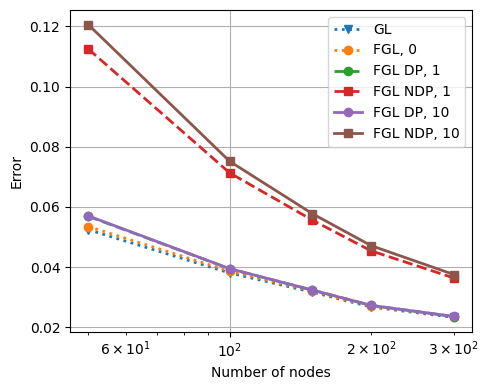

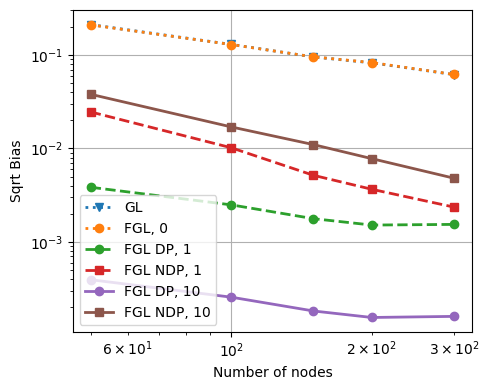

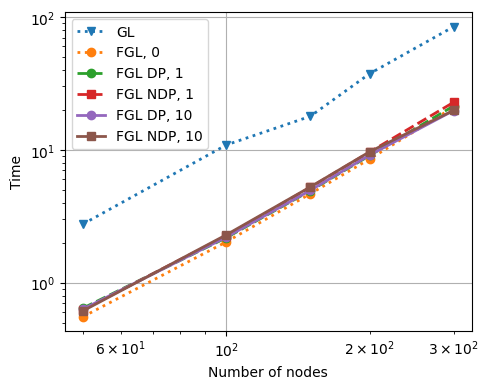

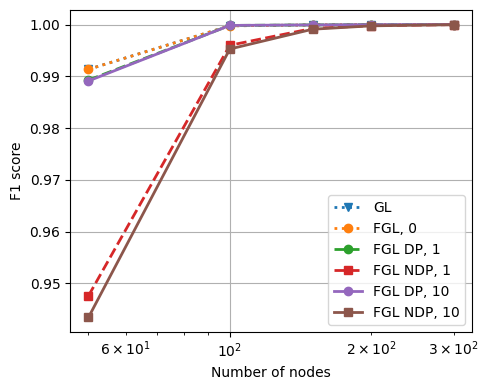

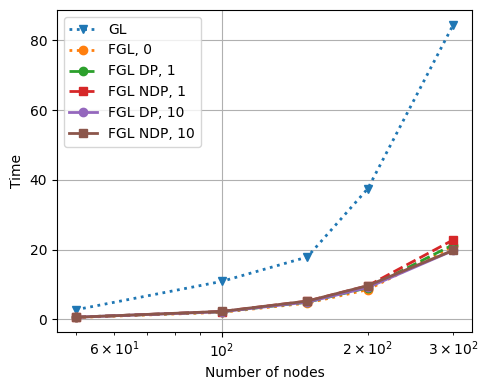

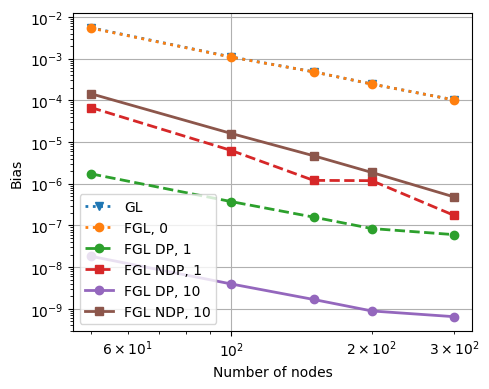

In [10]:
plt_args = { 'linewidth': 2 }
plot_results(DIM_RANGE, frob_err, Exps, y_label='Error', plt_args=plt_args)
plot_results(DIM_RANGE, sqrt_bias, Exps, y_label='Sqrt Bias', plt_args=plt_args, plot_f='loglog')
plot_results(DIM_RANGE, runingtimes, Exps, y_label='Time', plt_args=plt_args, plot_f='loglog')


# plot_results(DIM_RANGE, frob_err2, Exps, y_label='Error v2', plt_args=plt_args)
plot_results(DIM_RANGE, f1_score, Exps, y_label='F1 score', plt_args=plt_args)
plot_results(DIM_RANGE, runingtimes, Exps, y_label='Time', plt_args=plt_args, plot_f='semilogx')
plot_results(DIM_RANGE, bias, Exps, y_label='Bias', plt_args=plt_args, plot_f='loglog')




In [11]:
# # Load data
# file_name = PATH + 'vardim_graphs_v0'
# with open(file_name, 'rb') as f:
#     data = pickle.load(f)

# Exps = data['Exps']
# Thetas_est = data['Thetas_est']
# Thetas_true = data['Thetas_true']
# runingtimes = data['runingtimes']
# Zs = data['Zs']